In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
tests = [pd.read_csv(f"data/test/{i}.csv") for i in range(81)]
sample_submission = pd.read_csv("data/sample_submission.csv")

In [3]:
feature_time = ["Year", "Day", "Time"]
feature_

NameError: name 'feature_' is not defined

In [4]:
# DHI : Diffuse Horizontal Irrandiance // 수평면 산란일사량, 태양으로부터 직접 경로에 도달하지 않고 대기의 분자와 입자에 의해 산란된 단위 면적 당 방사선의 양
# DNI : Direct Normal Irradiance // 법선면 직달일사량, 태양의 방향에서 수직으로 유지되는 표면의 단위면적 당 태양 복사량
# WS  : Wind Speed         //
# RH  : Reletive humidity // 상대습도
# T   : Temperture
train = pd.read_csv("data/train/train.csv")
train.insert(0, "Year", np.floor(train.Day / 365))
train["Year"] = train.Year.astype(int)
train["Weekday"] = train["Day"] % 7
train["Day"] = train["Day"] % 365
train["Time"] = train.Hour + train.Minute / 60
train = train[['Year', 'Day', 'Time', 'Weekday', 'DHI', 'DNI', 'WS', 'RH', 'T', 'TARGET']]
train.sample(10)

,Year,Day,Time,Weekday,DHI,DNI,WS,RH,T,TARGET
15119,0,314,23.5,6,0,0,2.9,60.98,-3,0.000000
25536,1,167,0.0,0,0,0,2.3,49.13,14,0.000000
43544,2,177,4.0,4,0,0,4.5,56.52,14,0.000000
40078,2,104,23.0,1,0,0,0.7,69.19,6,0.000000
33474,1,332,9.0,4,122,288,3.8,42.05,-1,19.426724
23211,1,118,13.5,0,406,354,3.9,78.83,3,66.348262
32811,1,318,13.5,4,50,962,2.5,12.49,20,45.318562
30329,1,266,20.5,1,0,0,1.4,65.63,7,0.000000
33602,1,335,1.0,0,0,0,0.6,60.07,-3,0.000000
14728,0,306,20.0,5,0,0,3.1,46.30,7,0.000000


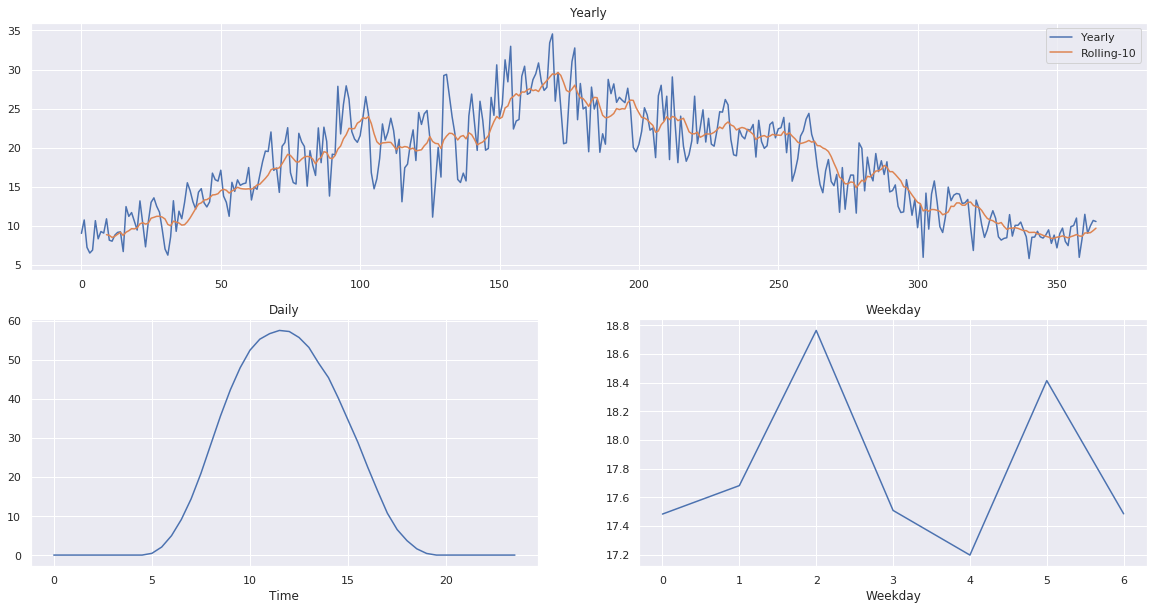

In [5]:
plt.figure(figsize=(20, 10))
plt.subplot(211)
yearly = train.groupby("Day").TARGET.mean()
plt.title("Yearly")
plt.plot(yearly, label="Yearly")
plt.plot(yearly.rolling(10).mean(), label="Rolling-10")
plt.legend()
plt.subplot(223)
train.groupby("Time").TARGET.mean().plot(title="Daily")
plt.subplot(224)
train.groupby("Weekday").TARGET.mean().plot(title="Weekday")
plt.show()

True    52560
dtype: int64

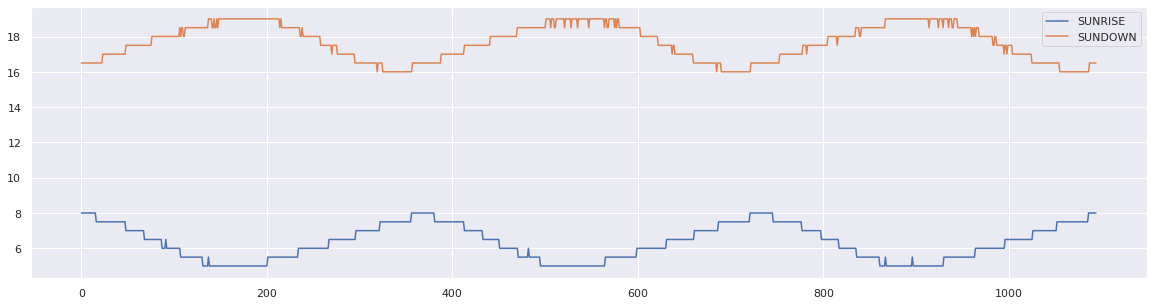

In [6]:
##### 일출/일몰 시간에 대한 고찰
# DHI 와 TARGET의 non-zero 인 위치가 전부 동일하다.
# 따라서 DHI를 기반으로 일출/일몰시간을 유추하는 것이 매우 합당함
# seasonality에 따른 일출/일몰 시간의 변동폭은 30분으로 매우 안정적으로 변화함
# 이 또한 feature 기반으로 변동성을 유추할 수 있으면 보정하여 사용하면 좋을 듯
display((train.DHI.ne(0) == train.TARGET.ne(0)).value_counts())
sun_appear = (
    train.loc[train.TARGET.ne(0), ["Year", "Day", "Time", "TARGET"]]
    .assign(Day=lambda df: df.Year * 365 + df.Day)
    .groupby("Day").Time
)
plt.figure(figsize=(20, 5))
plt.plot(sun_appear.first(), label="SUNRISE")
plt.plot(sun_appear.last(), label="SUNDOWN")
plt.legend()

In [7]:
# 일출 일몰 시간을 feature로 삽입
sunrise = sun_appear.first()
sunrise.name = "Sunrise"
sunset = sun_appear.last()
sunset.name = "Sunset"
train = train.merge(sunrise.reset_index())
train = train.merge(sunset.reset_index())
train.head()

,Year,Day,Time,Weekday,DHI,DNI,WS,RH,T,TARGET,Sunrise,Sunset
0,0,0,0.0,0,0,0,1.5,69.08,-12,0.0,8.0,16.5
1,0,0,0.5,0,0,0,1.5,69.06,-12,0.0,8.0,16.5
2,0,0,1.0,0,0,0,1.6,71.78,-12,0.0,8.0,16.5
3,0,0,1.5,0,0,0,1.6,71.75,-12,0.0,8.0,16.5
4,0,0,2.0,0,0,0,1.6,75.20,-12,0.0,8.0,16.5


In [19]:
# https://www.pveducation.org/pvcdrom/properties-of-sunlight/elevation-angle

# 한국원자력연구원 위도 경도 37.63358642997611, 127.08376293918955
phi = 37.63358642997611
delta = 23.4

train["TC"] = (24 - (train.Sunrise + train.Sunset)) * 30 # TC ; Time Correction
train["LST"] = train.Time + train.TC / 60 # LST ; Local Solar Time
train["HRA"] = 15 * (train.LST - 12) # HRA ; Hour Angle
train["EA"] = np.arcsin(np.sin(delta)*np.sin(phi) + np.cos(delta)*np.cos(phi)*np.cos(train.HRA))
train.sample(10)

,Year,Day,Time,Weekday,DHI,DNI,WS,RH,T,TARGET,Sunrise,Sunset,TC,LST,HRA,EA
10757,2,74,2.5,6,0,0,2.0,52.53,5,0.000000,6.5,17.5,0.0,2.50,-142.50,0.133911
18419,2,127,17.5,3,4,0,2.2,88.42,10,0.375350,5.5,18.5,0.0,17.50,82.50,-0.045323
30604,1,212,14.0,3,132,873,3.7,15.08,31,81.244574,5.5,19.0,-15.0,13.75,26.25,-0.005873
48690,0,338,9.0,2,88,573,1.3,76.61,1,23.274018,7.5,16.0,15.0,9.25,-41.25,0.213851
13913,1,96,20.5,6,0,0,0.9,75.03,5,0.000000,6.0,18.0,0.0,20.50,127.50,0.107042
2863,2,19,15.5,0,53,793,1.1,64.06,1,23.743252,7.5,16.5,0.0,15.50,52.50,0.164480
3017,2,20,20.5,1,0,0,1.3,79.57,-2,0.000000,7.5,16.5,0.0,20.50,127.50,0.107042
37734,0,262,3.0,3,0,0,1.4,50.11,8,0.000000,6.0,17.5,15.0,3.25,-131.25,-0.058791
38581,2,267,18.5,3,0,0,1.0,79.88,5,0.000000,6.5,17.5,0.0,18.50,97.50,0.226461
47880,1,332,12.0,4,151,574,3.5,34.49,0,39.979196,7.5,16.0,15.0,12.25,3.75,0.197933


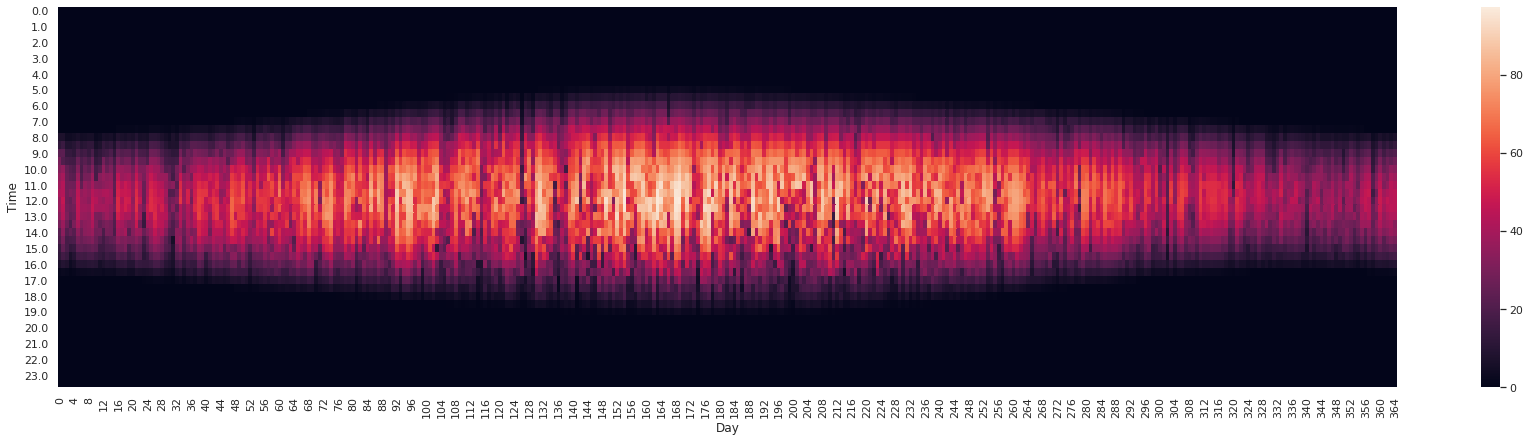

In [30]:
# Heatmap View
# 크게 Seasonality가 보이는 경향이 확실히 있음.
# 
plt.figure(figsize=(30, 7))
sns.heatmap(
    train[['Year', 'Day', 'Time', 'TARGET']]
    .groupby(["Day", "Time"]).TARGET.mean()
    .reset_index()
    .pivot("Time", "Day", "TARGET")
)

In [ ]:
def plotFeatureInDay(year, day, size,)

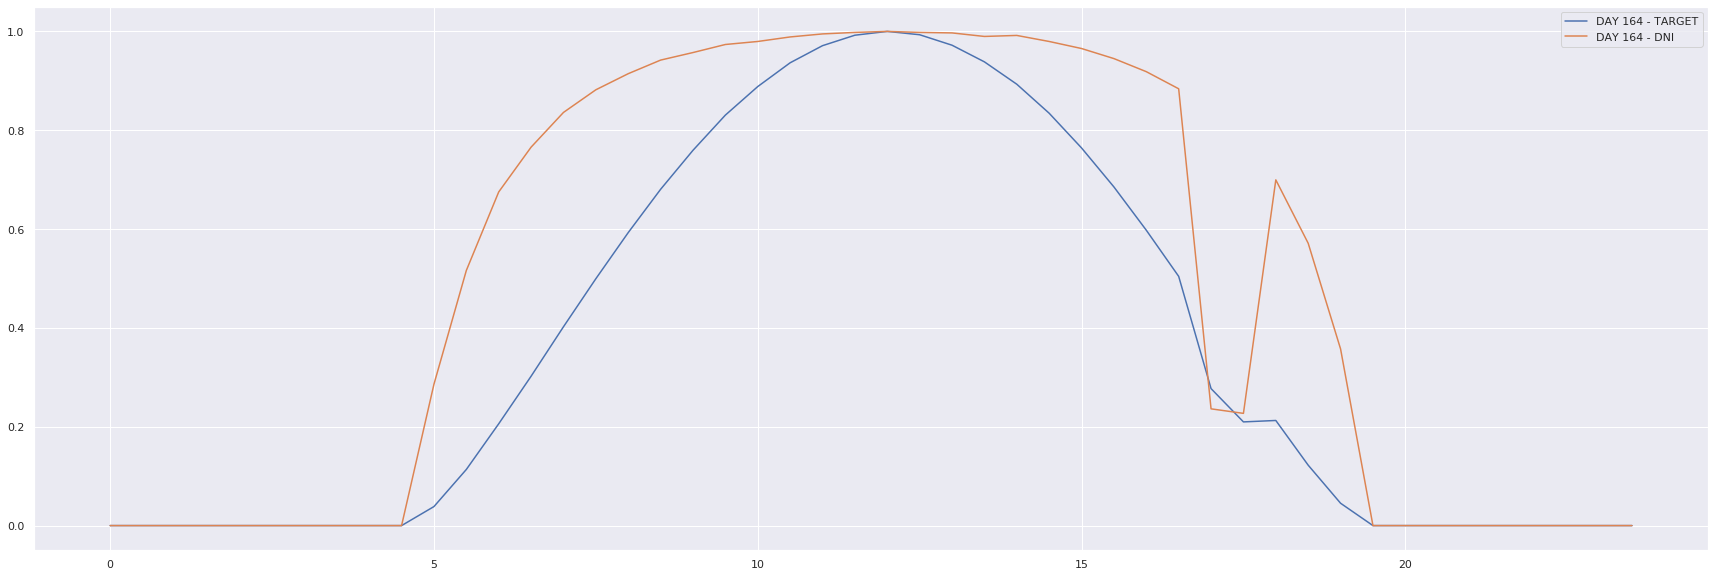

In [118]:
# DNI 가 더 stable한 변화를 보여줌. 안정적으로 예측하기 좋은 feature
# Elevation angle : https://www.pveducation.org/pvcdrom/properties-of-sunlight/elevation-angle
# sunrise 와 sunset 시간을 활용하여 TC(Time Correction)을 구하고,
# 이를 기반으로 HRA(Hour Angle)을 구하여, 현재 고도를 유추해볼 수 있음.
# 유추한 고도를 기반으로 DNI와 TARGET의 구체적인 관계식을 세워볼 수 있지 않을까 예상
plt.figure(figsize=(30, 10))
offset = 164
size = 1

for day in range(offset, offset+size):
    # 'DHI', 'DNI', 'WS', 'RH', 'T'
    aims = ["TARGET", "DNI"]
    for aim in aims:
        data = train.query("Year == 1").query(f"Day == {day}")[["Time", aim]].reset_index(drop=True).set_index("Time")
        data = data / data.max()
        plt.plot(data, label=f"DAY {day} - " + aim)
plt.legend()
plt.show()

In [8]:
train.groupby(["Year", "Day", "Time"])